# Програма

Описот на целосната постапка е вклучен во Jupyter книгата, па коментари околу кодот во Notebook-от се одлучивме да не вклучуваме.

In [ ]:
import cv2
import dlib
import numpy as np

In [ ]:
def extract_index_nparray(nparray):
    index = None

    for num in nparray[0]:
        index = num
        break

    return index

In [ ]:
img1 = cv2.imread("media/736px-Josip_Broz_Tito_uniform_portrait.jpg")
img2 = cv2.imread("media/768px-Queen_Elizabeth_II_of_New_Zealand_(cropped).jpg")

img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

mask = np.zeros_like(img1_gray)

In [ ]:
!wget -nd https://github.com/JeffTrain/selfie/raw/master/shape_predictor_68_face_landmarks.dat

--2021-07-04 09:42:01--  https://github.com/JeffTrain/selfie/raw/master/shape_predictor_68_face_landmarks.dat
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JeffTrain/selfie/master/shape_predictor_68_face_landmarks.dat [following]
--2021-07-04 09:42:01--  https://raw.githubusercontent.com/JeffTrain/selfie/master/shape_predictor_68_face_landmarks.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99693937 (95M) [application/octet-stream]
Saving to: ‘shape_predictor_68_face_landmarks.dat’

shape_predictor_68_ 100%[===================>]  95.08M   115MB/s    in 0.8s    

2021-07-04 09:42:03 (115 M

In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

In [ ]:
faces = detector(img1_gray)
for face in faces:
    landmarks = predictor(img1_gray, face)
    landmarks_points1 = []
    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmarks_points1.append((x, y))

    points = np.array(landmarks_points1, np.int32)
    convexhull = cv2.convexHull(points)
    cv2.fillConvexPoly(mask, convexhull, 255)

    rect = cv2.boundingRect(convexhull)
    subdiv = cv2.Subdiv2D(rect)
    subdiv.insert(landmarks_points1)
    triangles = subdiv.getTriangleList()
    triangles = np.array(triangles, dtype=np.int32)

    indexes_triangles = []
    for t in triangles:
        pt1 = t[0], t[1]
        pt2 = t[2], t[3]
        pt3 = t[4], t[5]

        index_pt1 = np.where((points == pt1).all(axis=1))
        index_pt1 = extract_index_nparray(index_pt1)

        index_pt2 = np.where((points == pt2).all(axis=1))
        index_pt2 = extract_index_nparray(index_pt2)

        index_pt3 = np.where((points == pt3).all(axis=1))
        index_pt3 = extract_index_nparray(index_pt3)

        if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
            triangle = [index_pt1, index_pt2, index_pt3]
            indexes_triangles.append(triangle)

In [ ]:
faces2 = detector(img2_gray)
for face in faces2:
    landmarks = predictor(img2_gray, face)
    landmarks_points2 = []
    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmarks_points2.append((x, y))

In [ ]:
img2_new_face = np.zeros((1024, 768, 3), np.uint8)

for triangle_index in indexes_triangles:
    pt1_1 = landmarks_points1[triangle_index[0]]
    pt2_1 = landmarks_points1[triangle_index[1]]
    pt3_1 = landmarks_points1[triangle_index[2]]

    tr1 = np.array([pt1_1, pt2_1, pt3_1], np.int32)
    rect1 = cv2.boundingRect(tr1)
    x, y, w, h = rect1
    cropped_triangle1 = img1[y: y + h, x: x + w]
    cropped_tr1_mask = np.zeros((h, w), np.uint8)

    points1 = np.array([[pt1_1[0] - x, pt1_1[1] - y], [pt2_1[0] - x, pt2_1[1] - y], [pt3_1[0] - x, pt3_1[1] - y]],
                       np.int32)
    cv2.fillConvexPoly(cropped_tr1_mask, points1, 255)
    cropped_triangle1 = cv2.bitwise_and(cropped_triangle1, cropped_triangle1, mask=cropped_tr1_mask)

    pt1_2 = landmarks_points2[triangle_index[0]]
    pt2_2 = landmarks_points2[triangle_index[1]]
    pt3_2 = landmarks_points2[triangle_index[2]]

    tr2 = np.array([pt1_2, pt2_2, pt3_2], np.int32)
    rect2 = cv2.boundingRect(tr2)
    x, y, w, h = rect2
    cropped_triangle2 = img2[y: y + h, x: x + w]
    cropped_tr2_mask = np.zeros((h, w), np.uint8)

    points2 = np.array([[pt1_2[0] - x, pt1_2[1] - y], [pt2_2[0] - x, pt2_2[1] - y], [pt3_2[0] - x, pt3_2[1] - y]],
                       np.int32)
    cv2.fillConvexPoly(cropped_tr2_mask, points2, 255)
    cropped_triangle2 = cv2.bitwise_and(cropped_triangle2, cropped_triangle2, mask=cropped_tr2_mask)

    points1 = np.float32(points1)
    points2 = np.float32(points2)

    M = cv2.getAffineTransform(points1, points2)

    warped_triangle = cv2.warpAffine(cropped_triangle1, M, (w, h))
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=cropped_tr2_mask)

    img2_new_face_rect_area = img2_new_face[y: y + h, x: x + w]
    img2_new_face_rect_area_gray = cv2.cvtColor(img2_new_face_rect_area, cv2.COLOR_BGR2GRAY)

    # _, mask_triangles_designed = cv2.threshold(img2_new_face_rect_area_gray, 64, 255, cv2.THRESH_BINARY_INV)
    # warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask_triangles_designed)

    img2_new_face_rect_area = cv2.add(img2_new_face_rect_area, warped_triangle)
    img2_new_face[y: y + h, x: x + w] = img2_new_face_rect_area

In [ ]:
convexhull2 = cv2.convexHull(np.array(landmarks_points2, np.int32))
img2_face_mask = np.zeros_like(img2_gray)
img2_head_mask = cv2.fillConvexPoly(img2_face_mask, convexhull2, 255)

img2_face_mask = cv2.bitwise_not(img2_head_mask)
img2_head_noface = cv2.bitwise_and(img2, img2, mask=img2_face_mask)

result = cv2.add(img2_head_noface, img2_new_face)

In [ ]:
x, y, w, h = cv2.boundingRect(convexhull2)
center_face2 = int((x + x + w) / 2), int((y + y + h) / 2)
seamlessclone = cv2.seamlessClone(result, img2, img2_head_mask, center_face2, cv2.MIXED_CLONE)

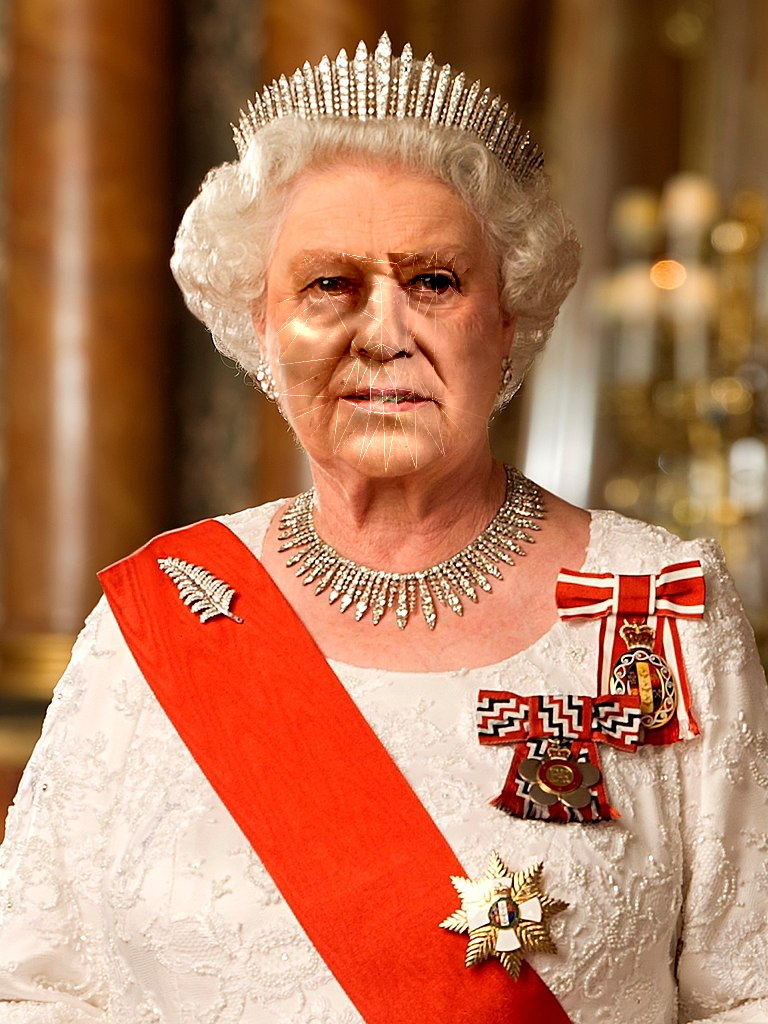

In [ ]:
cv2.imshow("End result", seamlessclone)